In [40]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [41]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Embedding, Bidirectional, Dropout, MaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [42]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        list_item.append(row[5])
        if row[0] == "0":
          list_item.append(0)
        else:
          list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


--2021-01-16 05:31:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   233MB/s    in 1.0s    

2021-01-16 05:31:18 (233 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [43]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [44]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0]) # YOUR CODE HERE
    labels.append(corpus[x][1]) # YOUR CODE HERE


tokenizer = Tokenizer()
tokenizer.fit_on_texts(
    # YOUR CODE HERE
    sentences
)

word_index = tokenizer.word_index
vocab_size=len(word_index) # YOUR CODE HERE

sequences = tokenizer.texts_to_sequences(sentences) # YOUR CODE HERE
padded = pad_sequences(sequences) # YOUR CODE HERE

split = int(test_portion * training_size)

test_sequences = padded[0:split] # YOUR CODE HERE
training_sequences = padded[split:] # YOUR CODE HERE
test_labels = labels[0:split] # YOUR CODE HERE
training_labels = labels[split:] # YOUR CODE HERE

In [45]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138861
1


In [46]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2021-01-16 05:31:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   230MB/s    in 1.4s    

2021-01-16 05:31:31 (230 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [47]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138862


In [57]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False, name="embedding_1"),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Conv1D(filters=64, kernel_size=5, activation="relu", name="conv1d_2"),
    Dense(units=64, activation="relu", name="dense_3"),
    Dense(units=1, activation="sigmoid", name="dense_4")
])
model.compile(
    # YOUR CODE HERE
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

num_epochs = 50
history = model.fit(
    training_sequences, 
    np.array(training_labels), 
    epochs=num_epochs, 
    validation_data=(test_sequences, np.array(test_labels)), 
    workers=-1,
    use_multiprocessing=True
)

print("Training Complete")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13886200  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
dense_3 (Dense)              (None, 12, 64)            4160      
_________________________________________________________________
dense_4 (Dense)              (None, 12, 1)             65        
Total params: 13,922,489
Trainable params: 36,289
Non-trainable params: 13,886,200
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 12s 3ms/step - loss: 0.6780 - accuracy: 0.5465 - val_loss: 0.6699 - val_accuracy: 0.5620
Epoch 2/50
4500/4500 [==============================] - 13s 3ms/step - loss: 0.6682 - accu

<Figure size 432x288 with 0 Axes>

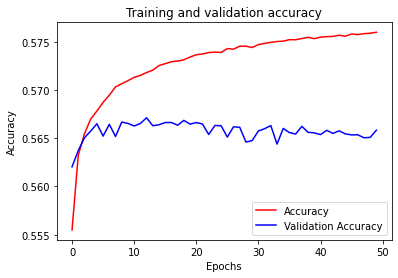

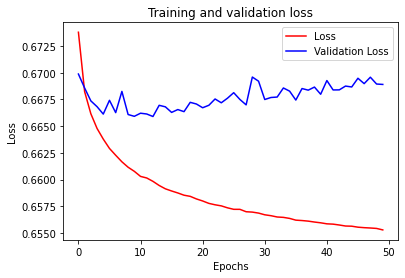

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [49]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False, name="embedding_1"),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Conv1D(filters=64, kernel_size=5, activation="relu", name="conv1d_2"),
    MaxPool1D(pool_size=4, name="pool1d_2"),
    Dense(units=64, activation="relu", name="dense_3"),
    Dense(units=1, activation="sigmoid", name="dense_4")
])
model.compile(
    # YOUR CODE HERE
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

num_epochs = 50
history = model.fit(
    training_sequences, 
    np.array(training_labels), 
    epochs=num_epochs, 
    validation_data=(test_sequences, np.array(test_labels)), 
    workers=-1,
    use_multiprocessing=True
)

print("Training Complete")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13886200  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
pool1d_2 (MaxPooling1D)      (None, 3, 64)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3, 64)             4160      
_________________________________________________________________
dense_4 (Dense)              (None, 3, 1)              65        
Total params: 13,922,489
Trainable params: 36,289
Non-trainable params: 13,886,200
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 13s 3ms/step - loss: 0.6694 - accuracy: 0.5640 

<Figure size 432x288 with 0 Axes>

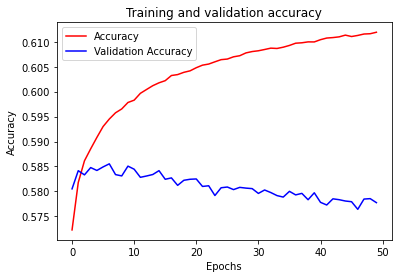

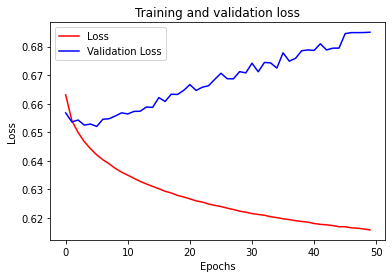

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [51]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False, name="embedding_1"),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Bidirectional(LSTM(units=64, return_sequences=False), name="LSTM_2"),
    Dense(units=64, activation="relu", name="dense_3"),
    Dense(units=1, activation="sigmoid", name="dense_4")
])
model.compile(
    # YOUR CODE HERE
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

num_epochs = 50
history = model.fit(
    training_sequences, 
    np.array(training_labels), 
    epochs=num_epochs, 
    validation_data=(test_sequences, np.array(test_labels)), 
    workers=-1,
    use_multiprocessing=True
)

print("Training Complete")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13886200  
_________________________________________________________________
LSTM_2 (Bidirectional)       (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,979,001
Trainable params: 92,801
Non-trainable params: 13,886,200
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 33s 7ms/step - loss: 0.5507 - accuracy: 0.7134 - val_loss: 0.4846 - val_accuracy: 0.7685
Epoch 2/50
4500/4500 [==============================] - 31s 7ms/step - loss: 0.4693 - accu

<Figure size 432x288 with 0 Axes>

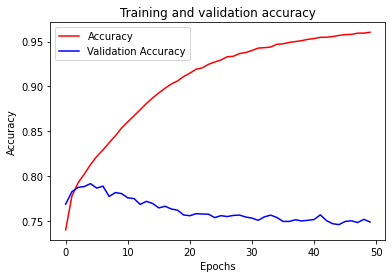

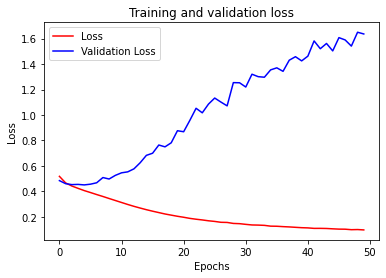

<Figure size 432x288 with 0 Axes>

In [52]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [53]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False, name="embedding_1"),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Bidirectional(LSTM(units=64, return_sequences=True), name="LSTM_2"),
    LSTM(units=64, return_sequences=False, name="LSTM_3"),
    Dense(units=64, activation="relu", name="dense_4"),
    Dense(units=1, activation="sigmoid", name="dense_5")
])
model.compile(
    # YOUR CODE HERE
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

num_epochs = 50
history = model.fit(
    training_sequences, 
    np.array(training_labels), 
    epochs=num_epochs, 
    validation_data=(test_sequences, np.array(test_labels)), 
    workers=-1,
    use_multiprocessing=True
)

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13886200  
_________________________________________________________________
LSTM_2 (Bidirectional)       (None, 16, 128)           84480     
_________________________________________________________________
LSTM_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 14,024,313
Trainable params: 138,113
Non-trainable params: 13,886,200
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 45s 9ms/step - loss: 0.5497 - accuracy: 0.7142

<Figure size 432x288 with 0 Axes>

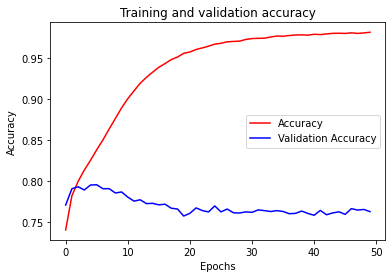

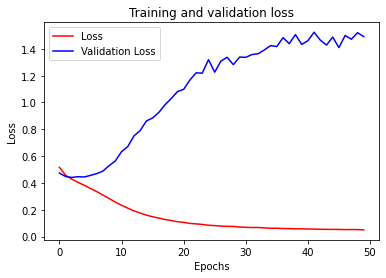

<Figure size 432x288 with 0 Axes>

In [54]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [55]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False, name="embedding_1"),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Dropout(rate=0.2, name="dropout_1"),
    Conv1D(filters=64, kernel_size=5, activation="relu", name="conv1d_2"),
    MaxPool1D(pool_size=4, name="pool1d_2"),
    LSTM(units=64, return_sequences=False, name="LSTM_3"),
    Dense(units=1, activation="sigmoid", name="dense_4")
])
model.compile(
    # YOUR CODE HERE
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

num_epochs = 50
history = model.fit(
    training_sequences, 
    np.array(training_labels), 
    epochs=num_epochs, 
    validation_data=(test_sequences, np.array(test_labels)), 
    workers=-1,
    use_multiprocessing=True
)

print("Training Complete")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13886200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
pool1d_2 (MaxPooling1D)      (None, 3, 64)             0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,951,353
Trainable params: 65,153
Non-trainable params: 13,886,200
_____________________________________

<Figure size 432x288 with 0 Axes>

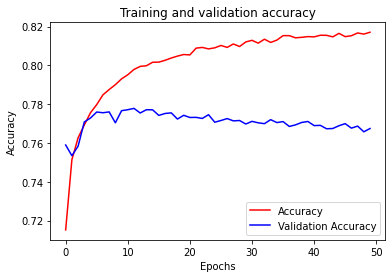

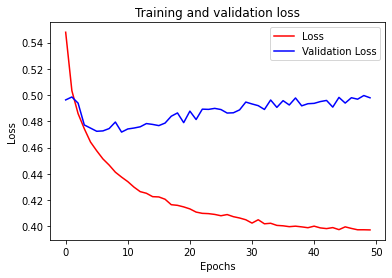

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!